In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, random, joblib, statistics
import sklearn as sk
import optuna
import xgboost as xgb
import plotly
import json
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm, datasets
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GroupKFold
import functions
import functionasy_svm
import math
from typing import List, Optional, Tuple
from tabulate import tabulate

random.seed(1213870)

## Meta Analysis Plot
meta analysis = 0.63 - 0.97

In [14]:

# Define folder paths for XGB and SVM results
folder_path_xgb = f"./results/xgb/test"

# Collect files from both folders
files_xgb = [
os.path.join(root, file)
for root, _, files in os.walk(folder_path_xgb)
for file in files
if '_classification_report' in file
]

# Initialize lists to store results
f1_scores_td = []
f1_scores_asd = []
f1_means = []
test_names = []
test_types = []

# Process files from both models
for file_path in files_xgb:

    filename = os.path.basename(file_path)
    name_suffix = filename.find('_participant_classification_report')
    test_name = filename[:name_suffix]
    test_names.append(test_name)
    if "MG" in test_name and "Qfam" in test_name:
        test_type = 'Different Task'
    elif "Qfam" in test_name and "Qunfam" in test_name:
        test_type = 'Different Familiarity'  
    else:
        test_type = 'Within'
    test_types.append(test_type)

    # Load classification report
    classification_report = pd.read_csv(file_path)

    # Extract F1 scores
    f1_td = classification_report.iloc[2, 0]
    f1_asd = classification_report.iloc[2, 1]
    f1_mean = np.mean([f1_td, f1_asd])
    f1_scores_td.append(f1_td)
    f1_scores_asd.append(f1_asd)
    f1_means.append(f1_mean)

# Combine results into a DataFrame
results = pd.DataFrame({
    'test_type': test_types,
    'test_name': test_names,
    'F1_score_td': f1_scores_td,
    'F1_score_asd': f1_scores_asd,
    'f1_mean': f1_means
})

# Sort the DataFrame by test_type
results = results.sort_values('test_type')

In [15]:
# formatting results correctly:
within = results[results['test_type'] == 'Within']
task = results[results['test_type'] == 'Different Task']
familiarity = results[results['test_type'] == 'Different Familiarity']
within = within[['f1_mean', 'test_type']]
task = task[['f1_mean', 'test_type']]
familiarity = familiarity[['f1_mean', 'test_type']]
meta = [0.63, 0.97]
metas = pd.DataFrame({'f1_mean': meta, 'test_type': 'Meta Analysis'})

# Concatenate into one DataFrame
data = pd.concat([metas, within, task, familiarity,])

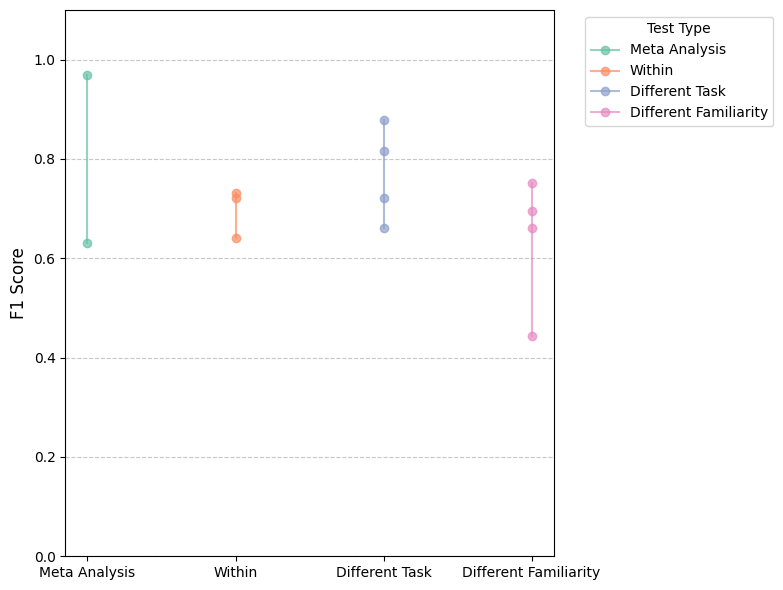

In [16]:

# Create the plot
plt.figure(figsize=(8, 6))

# Define a color palette for the categories (you can adjust this as needed)
palette = sns.color_palette("Set2", n_colors=len(data['test_type'].unique()))

# Plot lines connecting points within each category
for i, category in enumerate(data['test_type'].unique()):
    subset = data[data['test_type'] == category]
    # Plot line for each category
    plt.plot([category] * len(subset), subset['f1_mean'], 'o-', color=palette[i], alpha=0.7, label=category)

# Customize the plot
#plt.title("F1 Scores by Category", fontsize=16)
#plt.xlabel("Category", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.ylim(0, 1.1)  # Adjust y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend to the plot to distinguish categories
plt.legend(title="Test Type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()



In [17]:
# 2) How well do our models generalize
# Define folder paths for XGB and SVM results
folder_path_xgb = f"./results/xgb/test"

# Collect files from both folders
files_xgb = [
    os.path.join(root, file)
    for root, _, files in os.walk(folder_path_xgb)
    for file in files
    if '_classification_report' in file and 'Qunfam' not in file
]

# Initialize lists to store results
f1_scores_td = []
f1_scores_asd = []
f1_means = []
f1_mean_ebs = []
test_names = []
test_types = []
model_types = []

# Process files from both models
for file_path in files_xgb:

    filename = os.path.basename(file_path)
    name_suffix = filename.find('_participant_classification_report')
    test_name = filename[:name_suffix]
    test_names.append(test_name)
    if "MG" in test_name and "Qfam" in test_name and '80' in test_name:
        test_type = 'Different Task, Same Participants'
    elif "MG" in test_name and "Qfam" in test_name and '20' in test_name:
        test_type = 'Different Task, Different Participants'  
    else:
        test_type = 'Within'
    test_types.append(test_type)

    model_type = 'Matching Game' if test_name[0] == 'M' else 'Convo With Caregiver'
    model_types.append(model_type)

    # Load classification report
    classification_report = pd.read_csv(file_path)

    # Extract F1 scores
    f1_td = classification_report.iloc[2, 0]
    f1_asd = classification_report.iloc[2, 1]
    f1_mean = np.mean([f1_td, f1_asd])
    f1_scores_td.append(f1_td)
    f1_scores_asd.append(f1_asd)
    f1_means.append(f1_mean)

    # Load predictions to calculate sample size
    pred_file_path = [
        os.path.join(root, file)
        for root, _, files in os.walk(folder_path_xgb)
        for file in files
        if file == f'{test_name}_participant_predictions.csv'
    ]

    predictions = pd.read_csv(pred_file_path[0])
    n = predictions.shape[0]  # Sample size

    # calculate f1 error bars
    f1_mean_eb = ((f1_mean * (1 - f1_mean)) / n) ** 0.5
    f1_mean_ebs.append(f1_mean_eb)

# Combine results into a DataFrame
results = pd.DataFrame({
    'test_type': test_types,
    'model_type': model_types, 
    'test_name': test_names,
    'F1_score_td': f1_scores_td,
    'F1_score_asd': f1_scores_asd,
    'f1_mean': f1_means,
    'f1_mean_eb': f1_mean_ebs

})

# Sort the DataFrame by test_type
results = results.sort_values('test_type')
print(tabulate(results, headers='keys', tablefmt='psql'))

+----+----------------------------------------+----------------------+--------------+---------------+----------------+-----------+--------------+
|    | test_type                              | model_type           | test_name    |   F1_score_td |   F1_score_asd |   f1_mean |   f1_mean_eb |
|----+----------------------------------------+----------------------+--------------+---------------+----------------+-----------+--------------|
|  2 | Different Task, Different Participants | Matching Game        | MG_Qfam_20   |      0.615385 |       0.705882 |  0.660633 |    0.122256  |
|  4 | Different Task, Different Participants | Convo With Caregiver | Qfam_MG_20   |      0.666667 |       0.777778 |  0.722222 |    0.115648  |
|  0 | Different Task, Same Participants      | Matching Game        | MG_Qfam_80   |      0.866667 |       0.888889 |  0.877778 |    0.0570178 |
|  5 | Different Task, Same Participants      | Convo With Caregiver | Qfam_MG_80   |      0.8      |       0.833333 |  0.81

In [18]:
test_type_order = ['Within', 'Different Task, Same Participants', 'Different Task, Different Participants']

results['test_type'] = pd.Categorical(results['test_type'], categories=test_type_order, ordered=True)

# Sort the DataFrame by the 'test_type' column
results = results.sort_values('test_type')

Qfam = results[results['model_type'] == 'Convo With Caregiver']
MG = results[results['model_type'] == 'Matching Game']

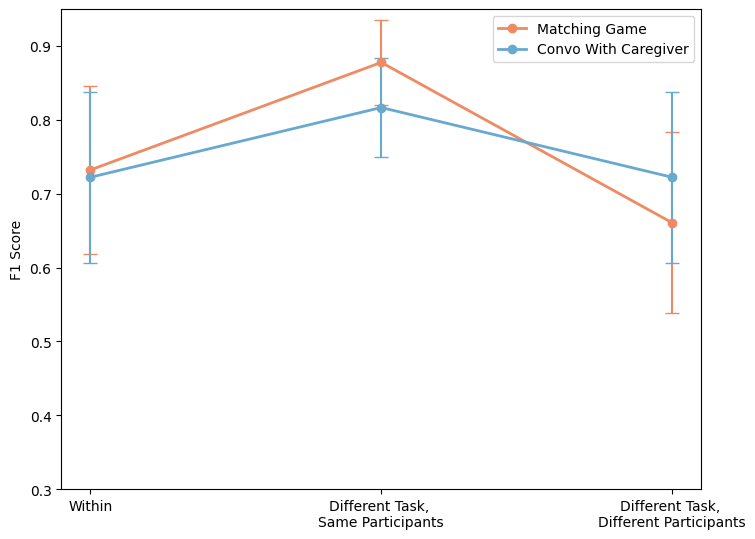

In [19]:
# Plotting results
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])  # Axes are as wide and high as the figure

# Cool colours
colours1 = ['#ef8a62', '#67a9cf']

# Add TD error bars (no connecting line)
ax.errorbar( # XGB
    MG['test_type'], 
    MG['f1_mean'],
    yerr=MG['f1_mean_eb'], 
    capsize=5, 
    color=colours1[0], 
    fmt='none'
)

# Add ASD error bars
ax.errorbar( # XGB
    Qfam['test_type'], 
    Qfam['f1_mean'], 
    yerr=Qfam['f1_mean_eb'], 
    capsize=5, 
    color=colours1[1], 
    fmt='none'
)

# Plot TD line - XGB
ax.plot(
    MG['test_type'], 
    MG['f1_mean'], 
    'o-', 
    label='Matching Game', 
    color=colours1[0], 
    linewidth=2
)

# Plot ASD line - XGB
ax.plot(
    Qfam['test_type'], 
    Qfam['f1_mean'], 
    'o-', 
    label='Convo With Caregiver', 
    color=colours1[1], 
    linewidth=2
)

# Labels and title
#ax.set_xlabel('Test set')
ax.set_ylabel('F1 Score')

labels = ['Within', 'Different Task, \nSame Participants', 'Different Task, \nDifferent Participants']
plt.xticks(ticks=range(len(labels)), labels=labels)

# Set y-axis limits
ax.set_ylim(0.3, 0.95)

# Show legend
ax.legend()
#ax.set_title('Task')

# Display plot
plt.show()

In [20]:
# 2) How well do our models generalize

folder_path_xgb = f"./results/xgb/test"

# Collect files from both folders
files_xgb = [
    os.path.join(root, file)
    for root, _, files in os.walk(folder_path_xgb)
    for file in files
    if '_classification_report' in file and 'MG' not in file
]

# Initialize lists to store results
f1_scores_td = []
f1_scores_asd = []
f1_means = []
f1_mean_ebs = []
test_names = []
test_types = []
model_types = []

# Process files from both models
for file_path in files_xgb:

    filename = os.path.basename(file_path)
    name_suffix = filename.find('_participant_classification_report')
    test_name = filename[:name_suffix]
    test_names.append(test_name)
    if "Qunfam" in test_name and "Qfam" in test_name and '80' in test_name:
        test_type = 'Different Familiarity, Same Participants'
    elif "Qunfam" in test_name and "Qfam" in test_name and '20' in test_name:
        test_type = 'Different Familiarity, Different Participants'  
    else:
        test_type = 'Within'
    test_types.append(test_type)

    model_type = 'Convo With Experimenter' if test_name[0:2] == 'Qu' else 'Convo With Caregiver'
    model_types.append(model_type)

    # Load classification report
    classification_report = pd.read_csv(file_path)

    # Extract F1 scores
    f1_td = classification_report.iloc[2, 0]
    f1_asd = classification_report.iloc[2, 1]
    f1_mean = np.mean([f1_td, f1_asd])
    f1_scores_td.append(f1_td)
    f1_scores_asd.append(f1_asd)
    f1_means.append(f1_mean)

    # Load predictions to calculate sample size
    pred_file_path = [
        os.path.join(root, file)
        for root, _, files in os.walk(folder_path_xgb)
        for file in files
        if file == f'{test_name}_participant_predictions.csv'
    ]

    predictions = pd.read_csv(pred_file_path[0])
    n = predictions.shape[0]  # Sample size

    # calculate f1 error bars
    f1_mean_eb = ((f1_mean * (1 - f1_mean)) / n) ** 0.5
    f1_mean_ebs.append(f1_mean_eb)

# Combine results into a DataFrame
results = pd.DataFrame({
    'test_type': test_types,
    'model_type': model_types, 
    'test_name': test_names,
    'F1_score_td': f1_scores_td,
    'F1_score_asd': f1_scores_asd,
    'f1_mean': f1_means,
    'f1_mean_eb': f1_mean_ebs

})

# Sort the DataFrame by test_type
results = results.sort_values('test_type')
print(tabulate(results, headers='keys', tablefmt='psql'))

+----+-----------------------------------------------+-------------------------+------------------+---------------+----------------+-----------+--------------+
|    | test_type                                     | model_type              | test_name        |   F1_score_td |   F1_score_asd |   f1_mean |   f1_mean_eb |
|----+-----------------------------------------------+-------------------------+------------------+---------------+----------------+-----------+--------------|
|  1 | Different Familiarity, Different Participants | Convo With Experimenter | Qunfam_Qfam_20   |      0.222222 |       0.666667 |  0.444444 |    0.1283    |
|  4 | Different Familiarity, Different Participants | Convo With Caregiver    | Qfam_Qunfam_20   |      0.615385 |       0.705882 |  0.660633 |    0.122256  |
|  0 | Different Familiarity, Same Participants      | Convo With Experimenter | Qunfam_Qfam_80   |      0.555556 |       0.833333 |  0.694444 |    0.0801875 |
|  5 | Different Familiarity, Same Parti

In [21]:
test_type_order = ['Within', 'Different Familiarity, Same Participants', 'Different Familiarity, Different Participants']

results['test_type'] = pd.Categorical(results['test_type'], categories=test_type_order, ordered=True)

# Sort the DataFrame by the 'test_type' column
results = results.sort_values('test_type')

Qfam = results[results['model_type'] == 'Convo With Caregiver']
Qunfam = results[results['model_type'] == 'Convo With Experimenter']

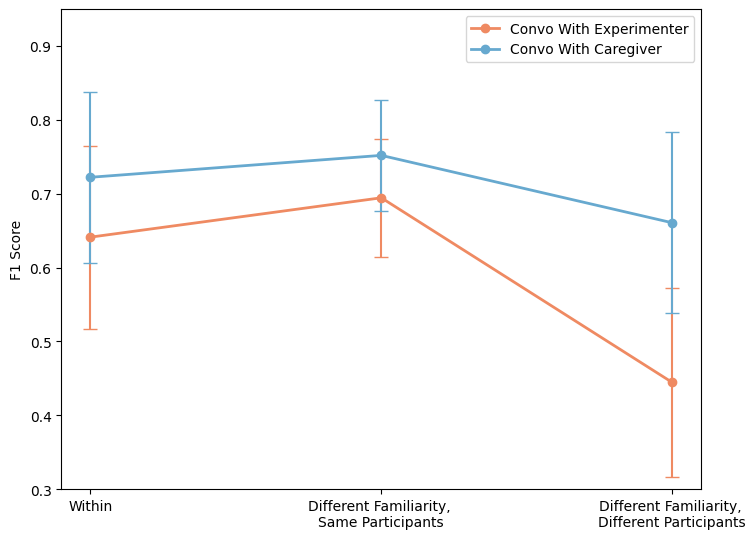

In [22]:
# Plotting results
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])  # Axes are as wide and high as the figure

# Cool colours
colours1 = ['#ef8a62', '#67a9cf']

# Add TD error bars (no connecting line)
ax.errorbar( # XGB
    Qunfam['test_type'], 
    Qunfam['f1_mean'],
    yerr=Qunfam['f1_mean_eb'], 
    capsize=5, 
    color=colours1[0], 
    fmt='none'
)

# Add ASD error bars
ax.errorbar( # XGB
    Qfam['test_type'], 
    Qfam['f1_mean'], 
    yerr=Qfam['f1_mean_eb'], 
    capsize=5, 
    color=colours1[1], 
    fmt='none'
)

# Plot TD line - XGB
ax.plot(
    Qunfam['test_type'], 
    Qunfam['f1_mean'], 
    'o-', 
    label='Convo With Experimenter', 
    color=colours1[0], 
    linewidth=2
)

# Plot ASD line - XGB
ax.plot(
    Qfam['test_type'], 
    Qfam['f1_mean'], 
    'o-', 
    label='Convo With Caregiver', 
    color=colours1[1], 
    linewidth=2
)

# Labels and title
#ax.set_xlabel('Test set')
ax.set_ylabel('F1 Score')

labels = ['Within', 'Different Familiarity, \nSame Participants', 'Different Familiarity, \nDifferent Participants']
plt.xticks(ticks=range(len(labels)), labels=labels)

# Show legend
ax.legend()

# Set y-axis limits
ax.set_ylim(0.3, 0.95)

# Display plot
plt.show()